# Reading files

In [167]:
import pandas as pd

laml = pd.read_csv("tcga_laml.maf", sep = '\t')
annot = pd.read_csv("tcga_laml_annot.tsv", sep = '\t')

In [168]:
l = []
for i in range(0,len(laml["Variant_Type"])):
    if laml["Variant_Type"][i] == "INS":
        if laml["Variant_Classification"][i] not in l:
            l.append(laml["Variant_Classification"][i])

In [169]:
Gene_ID = []
for j , i in enumerate(laml["Hugo_Symbol"]):
    if i not in Gene_ID:
        Gene_ID.append(i)
print(len(Gene_ID))

1611


In [170]:
barcodes = []
for j , i in enumerate(laml["Tumor_Sample_Barcode"]):
    if i not in barcodes:
        barcodes.append(i)

print(len(barcodes))

193


# Constructing transverssion & oncoplot Matrices

In [171]:
import pandas as pd
import numpy as np

a = np.zeros((1611,193),dtype=int)
df = pd.DataFrame(a, index=Gene_ID, columns=barcodes)
mutations_list = ["C>A","C>G","C>T","T>C","T>G","T>A"]
b = np.zeros((6,193),dtype=int)
df_mut = pd.DataFrame(b, index=mutations_list, columns=barcodes)

#reurns the complement of the nucleotide
def dna_complement(a):
    if a == "A":
        return "T"
    if a == "C":
        return "G"
    if a == "G":
        return "C"
    if a == "T":
        return "A"
    
    return

#this function returns the mutation a to b 
def mis_mut_classification(ref_allele, T_allele1, T_allele2):
    a = ref_allele
    if ref_allele == T_allele1:
        b = T_allele2
    else:
        b = T_allele1
    
    if ref_allele == "G":
        a = dna_complement(ref_allele)
        b = dna_complement(b)
    if ref_allele == "A":
        a = dna_complement(ref_allele)
        b = dna_complement(b) 
    
    return a + ">" + b

def variant_fun(vs):
    if vs == "Splice_Site":
        return 1
    if vs == "Missense_Mutation":
        return 2
    if vs == "Frame_Shift_Del":
        return 3
    if vs == "Nonsense_Mutation":
        return 4
    if vs == "Frame_Shift_Ins":
        return 5
    if vs == "In_Frame_Del":
        return 6
    if vs == "In_Frame_Ins":
        return 7
    return 0


for i in range(0,len(laml["Hugo_Symbol"])):
    gene = laml["Hugo_Symbol"][i]
    bar = laml["Tumor_Sample_Barcode"][i]
    var_type = laml["Variant_Type"][i]
    variant_class = variant_fun(laml["Variant_Classification"][i])
    if var_type == "SNP":
        mut = mis_mut_classification(laml["Reference_Allele"][i], laml["Tumor_Seq_Allele1"][i], laml["Tumor_Seq_Allele2"][i])
        df_mut[bar][mut] += 1
    
    if df[bar][gene] != 0:
        df[bar][gene] = 8
    else:
        df[bar][gene] = variant_class



In [172]:
def sort_rows(rows, mat):
    new_rows = []
    l = []
    for i in range(0,len(rows)):
        if mat["Num"][rows[i]] == mat["Num"][rows[i-1]]:
            l.append(rows[i])
        else:
            new_rows = new_rows + sorted(l)
            l = []
            l.append(rows[i])
            
    new_rows = new_rows + sorted(l)
    return new_rows
def sort_onco(i, cols, mat ,rows):
    l1 = []
    l2 = []
    if i >= len(rows):
        return cols
    gene = rows[i]
    for j in cols:
        if mat[j][gene] != 0:
            l1.append(j)
        else:
            l2.append(j)
    l3 = sort_onco(i+1, l1, mat ,rows)
    l4 = sort_onco(i+1, l2, mat ,rows)
    return l3 + l4

def altered(cols,rows,mat):
    alt_rows = []
    for col in cols:
        alter = False
        count = 0
        while not alter:
            if df[col][rows[count]] != 0:
                alter = True
            count += 1
            if count >= len(rows):
                break
        if alter:
            alt_rows.append(col)
    
    return alt_rows

df = df.assign(Num = np.zeros((1611),dtype = int))

for j in df.index[:]:
    c = 0
    for i in df.columns:
        if df[i][j] != 0:
            c += 1
    df["Num"][j] = c

df = df.sort_values(by=['Num'],ascending=False)

rows = sort_rows(df.index[:20],df)
cols1 = df.columns[:193]
cols2 = altered(cols1,df.index[:20],df)

sorted_barcodes = []
a = 0
sorted_barcodes = sort_onco(a,cols2,df,rows)

l_final = []
for j in rows:
    l = []
    for i in sorted_barcodes:
        l.append(df[i][j])
    l_final.append(l)
df2 = pd.DataFrame(l_final, index=rows, columns=sorted_barcodes)

df_mut = df_mut[sorted_barcodes]


# Calculating the TMB per sample

In [173]:
c = np.zeros((7,193),dtype=int)
var_list = ['3','5','6','7','2','4','1']
df_tmb = pd.DataFrame(c, index=var_list, columns=barcodes)



def variant_fun(vs):
    if vs == "Splice_Site":
        return 1
    if vs == "Missense_Mutation":
        return 2
    if vs == "Frame_Shift_Del":
        return 3
    if vs == "Nonsense_Mutation":
        return 4
    if vs == "Frame_Shift_Ins":
        return 5
    if vs == "In_Frame_Del":
        return 6
    if vs == "In_Frame_Ins":
        return 7
    return 0

for i in range(0,len(laml["Hugo_Symbol"])):
    bar = laml["Tumor_Sample_Barcode"][i]
    variant_class = variant_fun(laml["Variant_Classification"][i])
    if variant_class != 0:
        df_tmb[bar][str(variant_class)] += 1


df_tmb = df_tmb[sorted_barcodes]

# Calculating the differnet number of mutations per gene

In [174]:
e = np.zeros((20,8),dtype=int)
var_list2 = ['7','3','2','6','5','4','1','8']
df_gene = pd.DataFrame(e, index=rows, columns=var_list2)

for j in df2.index[:]:
    for i in df2.columns[:]:
        if df2[i][j] != 0:
            variant = str(df2[i][j])
            df_gene[variant][j] += 1


# Normalizing the transversion Matrix

In [175]:

d = np.zeros((6,159),dtype=float)
df_mut2 = pd.DataFrame(d, index=mutations_list, columns=sorted_barcodes)

for i in df_mut.columns[:]:
    count = 0
    for j in df_mut.index[:]:
        count += df_mut[i][j]
    for k in df_mut2.index[:]:
        if count == 0:
            break
        new_value = df_mut[i][k] / count
        df_mut2[i][k] = new_value
    

# Visualize the Oncoplot

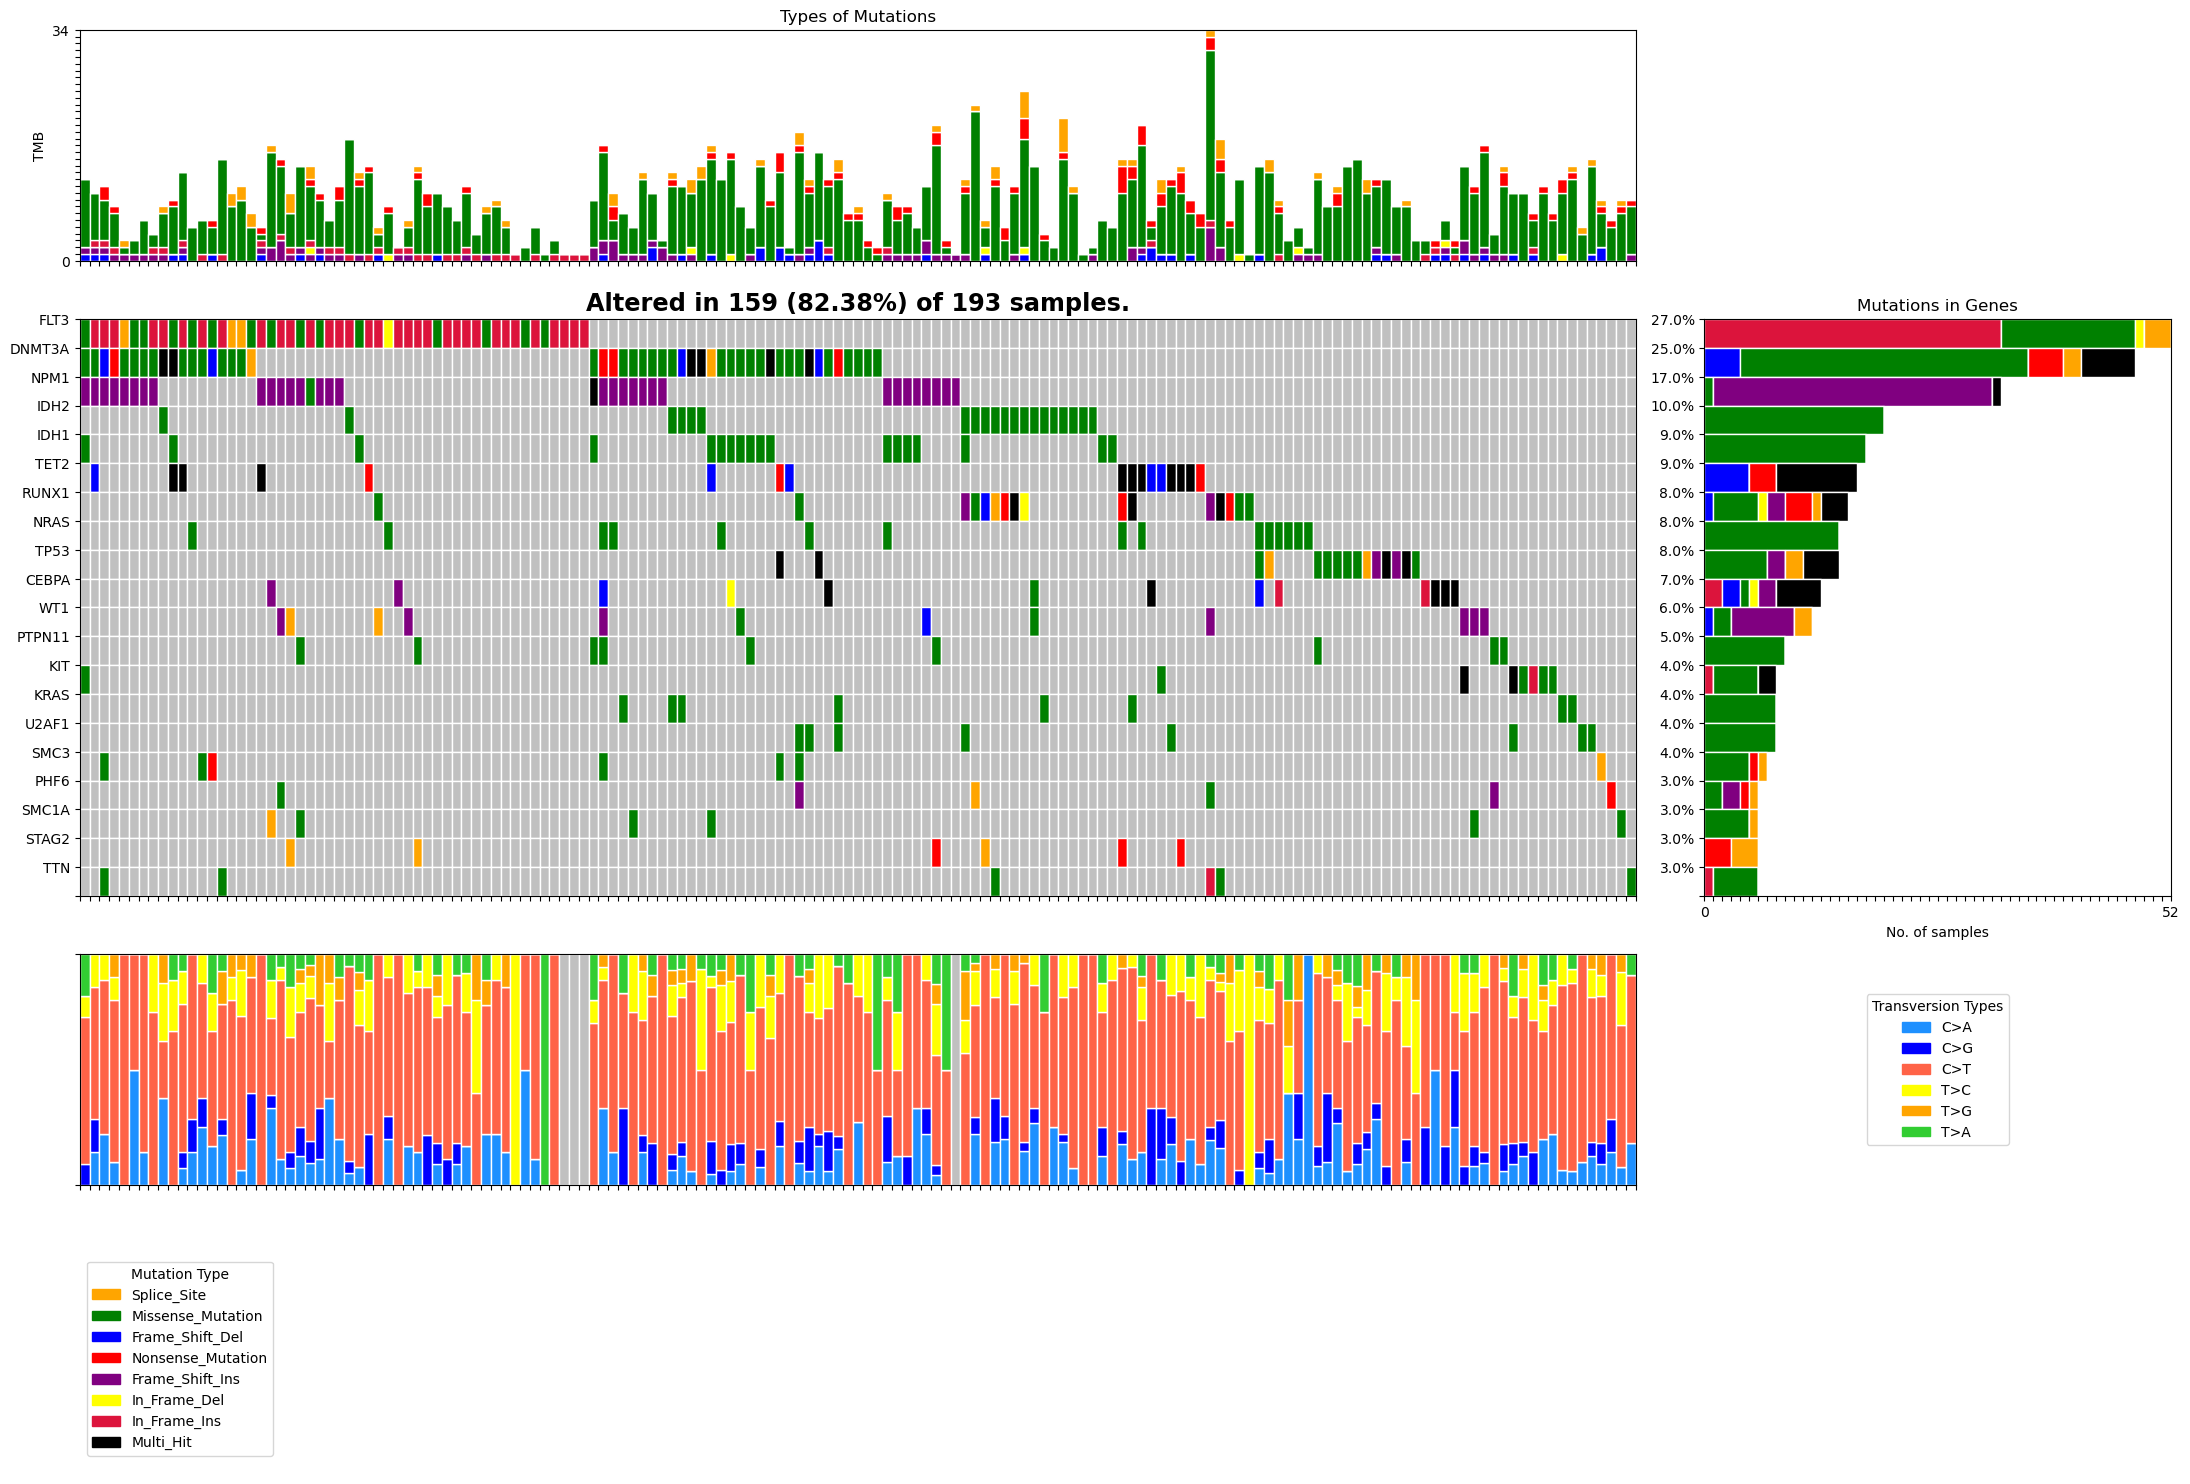

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

def color_class(a):
    if a == 0:
        return "silver"
    if a == 1:
        return "orange"
    if a == 2:
        return "green"
    if a == 3:
        return "blue"
    if a == 4:
        return "red"
    if a == 5:
        return "purple"
    if a == 6:
        return "yellow"
    if a == 7:
        return "crimson"
    if a == 8:
        return "black"    
    return

def color_mut(mut):
    if mut == 'C>A':
        return 'dodgerblue'
    if mut == 'C>G':
        return 'blue'
    if mut == 'C>T':
        return 'tomato'
    if mut == 'T>C':
        return 'yellow'
    if mut == 'T>G':
        return 'orange'
    if mut == 'T>A':
        return 'limegreen'


genes_num = len(rows)
samples_num = len(sorted_barcodes)
total_sam_num = len(barcodes)
altered_per = round((100*samples_num / total_sam_num),2)

# Create figure and gridspec
fig = plt.figure(figsize=(22, 15))
gs = gridspec.GridSpec(4, 2, height_ratios=[2, 5, 2, 2], width_ratios=[5, 1.5])

# Top plot: for types of mutation in different samples
ax1 = plt.subplot(gs[0, 0])
max_count = 0
for i, sample in enumerate(df_tmb.columns[:]):
    count = 0
    for mut in df_tmb.index[:]:
        n_count = df_tmb[sample][mut]
        count = count + n_count
        color = color_class(int(mut))
        rect = Rectangle((i,(count - n_count)), 1, n_count, facecolor=color, edgecolor='white')
        ax1.add_patch(rect)
    if count > max_count:
        max_count = count

x_lables = [""]*(samples_num+1)
y_lables = [""]*(max_count+1)
y_lables[max_count] = max_count
y_lables[0] = 0
ax1.set_yticks(np.arange(max_count+1))
ax1.set_yticklabels(y_lables)
ax1.set_xticks(np.arange(samples_num+1))
ax1.set_xticklabels(x_lables)
ax1.set_title('Types of Mutations')
ax1.set_ylabel('TMB')

# Oncoplot: Mutation types by color for different genes and samples
ax2 = plt.subplot(gs[1, 0])

for j, gene in enumerate(df2.index[:]):
    for i, sample in enumerate(df2.columns[:]):
        color = color_class(df2[sample][gene])
        rect = Rectangle((i,genes_num - 1 -j), 1, 1, facecolor=color, edgecolor='white')
        ax2.add_patch(rect)


x_lables = [""]*(samples_num+1)
ax2.set_yticks(np.arange(genes_num+1))
rows.reverse()
ax2.set_yticklabels([""]+rows)
rows.reverse()
ax2.set_xticks(np.arange(samples_num+1))
ax2.set_xticklabels(x_lables)
ax2.set_title('Altered in %s (%s) of %s samples.'%(samples_num,str(altered_per)+'%',total_sam_num),size = 'xx-large', weight = 'bold')


# Different types of mutations in genes
ax3 = plt.subplot(gs[1, 1])
y_lables = []
max_count = 0
for j, gene in enumerate(df_gene.index[:]):
    count = 0
    for mut in df_gene.columns[:]:
        n_count = df_gene[mut][gene]
        count = count + n_count
        color = color_class(int(mut))
        rect = Rectangle(((count - n_count),genes_num - 1 -j),n_count,1, facecolor=color, edgecolor='white')
        ax3.add_patch(rect)
    if count > max_count:
        max_count = count
    gene_per = str(round(100*count/total_sam_num,0)) + '%'
    y_lables.append(gene_per)
    
    
x_lables = [""]*(max_count+1)
y_lables = y_lables + [""]
y_lables.reverse()
x_lables[max_count] = max_count
x_lables[0] = 0
ax3.set_yticks(np.arange(genes_num+1))
ax3.set_yticklabels(y_lables)
ax3.set_xticks(np.arange(max_count+1))
ax3.set_xticklabels(x_lables)
ax3.set_title('Mutations in Genes')
ax3.set_xlabel('No. of samples')

# Bottom plot: Different types of missense mutations in different samples
ax4 = plt.subplot(gs[2, 0])

for i, sample in enumerate(df_mut2.columns[:]):
    ratio = 0
    for mut in df_mut2.index[:]:
        n_ratio = df_mut2[sample][mut]
        ratio = ratio + n_ratio
        color = color_mut(mut)
        rect = Rectangle((i,(ratio - n_ratio)), 1, n_ratio, facecolor=color, edgecolor='white')
        ax4.add_patch(rect)
    if ratio == 0:
        color = 'silver'
        rect = Rectangle((i,0), 1, 1, facecolor=color, edgecolor='white')
        ax4.add_patch(rect)

x_lables = [""]*(samples_num+1)
y_lables = [""]*2
ax4.set_yticks(np.arange(2))
ax4.set_yticklabels(y_lables)
ax4.set_xticks(np.arange(samples_num+1))
ax4.set_xticklabels(x_lables)


# Legend for oncoplot
ax5 = plt.subplot(gs[3, 0])
legend_handles = []
for i in range(1,9):
    color = color_class(i)
    rect = Rectangle((0, i), 1, 1, color = color)
    legend_handles.append(rect)
mut_types = ["Splice_Site","Missense_Mutation","Frame_Shift_Del","Nonsense_Mutation",
             "Frame_Shift_Ins","In_Frame_Del","In_Frame_Ins","Multi_Hit" ]
ax5.legend(handles=legend_handles, labels = mut_types , title='Mutation Type', loc='center left')
ax5.axis('off')

# Legend for transversion
ax6 = plt.subplot(gs[2, 1])
legend_handles = []
for i, mut in enumerate(df_mut2.index[:]):
    color = color_mut(mut)
    rect = Rectangle((0, i), 1, 1, color = color)
    legend_handles.append(rect)
transversions = ['C>A', 'C>G', 'C>T', 'T>C', 'T>G', 'T>A']
ax6.legend(handles=legend_handles, labels = transversions , title='Transversion Types', loc='center')
ax6.axis('off')


plt.tight_layout()
plt.show()